In [52]:
import sys
from pathlib import Path

project_root = Path().resolve().parent 
sys.path.append(str(project_root))

project_root

WindowsPath('D:/Workspace/Repository/ml-research-lab/spiral-drawing-digital-engine')

In [53]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from argparse import ArgumentParser

torch.set_float32_matmul_precision('medium')

In [54]:
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.models as models
from lightning.pytorch import LightningDataModule
from sklearn.model_selection import KFold

In [55]:
import os
from typing import Optional, List, Dict, Any

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Load Dataset

In [57]:
data_dir = Path(project_root) / "data" / "kmader"
train_dir = data_dir / "training"
test_dir = data_dir / "testing"

# DataLoader

In [58]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights

weights = EfficientNet_B1_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()
preprocess_transform

ImageClassification(
    crop_size=[240]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [59]:
class SpiralDrawingsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Custom dataset for spiral drawings classification (healthy vs parkinson)
        Args:
            root_dir: Root directory containing 'healthy' and 'parkinson' subdirectories
            transform: Optional transforms to apply to images
        """
        self.dataset = ImageFolder(root_dir, transform=transform)
        self.classes = self.dataset.classes
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        return self.dataset[idx]

In [60]:
class SpiralDrawingsKFoldDataModule(LightningDataModule):
    def __init__(self, 
                data_dir: str = "d:/Workspace/Repository/ml-research-lab/spiral-drawing-digital-engine/data/kmader",
                k: int = 1,  # fold number
                split_seed: int = 12345,
                num_splits: int = 10,
                batch_size: int = 32,
                num_workers: int = 0,
                pin_memory: bool = False,
                use_test_set: bool = True,  # Whether to use the separate test set
            ):
            super().__init__()
            
            # Save hyperparameters
            self.save_hyperparameters(logger=False)
            
            # Validation for k parameter
            assert 1 <= k <= num_splits, f"Fold number k must be between 1 and {num_splits}"
            
            # Get official transforms for EfficientNet B1
            weights = EfficientNet_B1_Weights.IMAGENET1K_V1
            self.val_transforms = weights.transforms()
            
            # For training, add augmentations before the official transforms
            self.train_transforms = transforms.Compose([
                # First resize to standard size used by EfficientNet
                transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
                # Then apply augmentations
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(brightness=0.1, contrast=0.1),
                # Then apply center crop, to-tensor and normalization
                transforms.CenterCrop(240),  # EfficientNetB1 uses 240x240
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            
            # Placeholder for datasets
            self.data_train: Optional[Dataset] = None
            self.data_val: Optional[Dataset] = None
            self.data_test: Optional[Dataset] = None

    @property
    def num_classes(self) -> int:
        return 2  # healthy and parkinson

    def setup(self, stage=None):
        # Training dataset with augmentations
        train_dataset = SpiralDrawingsDataset(
            os.path.join(self.hparams.data_dir, "training"),
            transform=self.train_transforms
        )
        
        # Set up cross-validation splits
        kf = KFold(n_splits=self.hparams.num_splits, shuffle=True, random_state=self.hparams.split_seed)
        all_indices = np.arange(len(train_dataset))
        all_splits = list(kf.split(all_indices))
        
        # Get indices for the specified fold
        train_indices, val_indices = all_splits[self.hparams.k - 1]  # k is 1-indexed
        
        # Create subsets for training and validation
        self.data_train = Subset(train_dataset, train_indices)
        
        # For validation, use val indices but with val transforms
        val_dataset = SpiralDrawingsDataset(
            os.path.join(self.hparams.data_dir, "training"),
            transform=self.val_transforms
        )
        self.data_val = Subset(val_dataset, val_indices)
        
        # Set up test dataset if needed
        if self.hparams.use_test_set:
            self.data_test = SpiralDrawingsDataset(
                os.path.join(self.hparams.data_dir, "testing"),
                transform=self.val_transforms
            )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
        )
    
    def test_dataloader(self):
        if self.data_test:
            return DataLoader(
                dataset=self.data_test,
                batch_size=self.hparams.batch_size,
                num_workers=self.hparams.num_workers,
                pin_memory=self.hparams.pin_memory,
            )
        return None

# Model Building

In [61]:
class SpiralDrawingModel(L.LightningModule):
    def __init__(
        self, 
        learning_rate: float = 1e-4,
        weight_decay: float = 5e-3,
        freeze_backbone: bool = False,
        dropout_rate: float = 0.6,  
        unfreeze_layers: int = 50  # Number of layers to unfreeze from the end
    ):
        super().__init__()
        self.save_hyperparameters()
        
        # Load pre-trained EfficientNetB1
        self.model = models.efficientnet_b1(weights="IMAGENET1K_V1")
        
        # Get number of features from the model
        num_features = self.model.classifier[1].in_features  
        
        # Handle freezing/unfreezing based on parameter
        if freeze_backbone:
            # Freeze all backbone layers
            for param in self.model.features.parameters():
                param.requires_grad = False
        elif unfreeze_layers > 0:
            # Freeze all layers first
            for param in self.model.features.parameters():
                param.requires_grad = False
            
            # Then unfreeze the last n layers
            features_children = list(self.model.features.children())
            layers_to_unfreeze = min(unfreeze_layers, len(features_children))
            
            for i in range(len(features_children) - layers_to_unfreeze, len(features_children)):
                for param in features_children[i].parameters():
                    param.requires_grad = True

        # Replace the classifier with our custom classifier
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate - 0.1),
            nn.Linear(512, 2)  # 2 classes for binary classification
        )
        
        # Define metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=2)
        self.val_acc = Accuracy(task="multiclass", num_classes=2)
        self.test_acc = Accuracy(task="multiclass", num_classes=2)
        
        # Additional metrics for validation
        self.val_precision = Precision(task="multiclass", num_classes=2, average='macro')
        self.val_recall = Recall(task="multiclass", num_classes=2, average='macro')
        self.val_f1 = F1Score(task="multiclass", num_classes=2, average='macro')
        self.val_auroc = AUROC(task="multiclass", num_classes=2)

    def forward(self, x):
        # The entire model is now a single unit
        return self.model(x)
    
    # The rest of the methods remain the same
    def _shared_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y, logits
    
    
    def training_step(self, batch, batch_idx):
        loss, preds, targets, _ = self._shared_step(batch)
        
        # Log metrics
        self.train_acc(preds, targets)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train/acc", self.train_acc, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, preds, targets, logits = self._shared_step(batch)
        
        # Log metrics
        self.val_acc(preds, targets)
        self.val_precision(preds, targets)
        self.val_recall(preds, targets)
        self.val_f1(preds, targets)
        self.val_auroc(F.softmax(logits, dim=1), targets)
        
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/acc", self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/precision", self.val_precision, on_step=False, on_epoch=True)
        self.log("val/recall", self.val_recall, on_step=False, on_epoch=True)
        self.log("val/f1", self.val_f1, on_step=False, on_epoch=True)
        self.log("val/auroc", self.val_auroc, on_step=False, on_epoch=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, preds, targets, _ = self._shared_step(batch)
        
        # Log metrics
        self.test_acc(preds, targets)
        self.log("test/loss", loss, on_epoch=True)
        self.log("test/acc", self.test_acc, on_epoch=True)
        
        return loss
    
    def configure_optimizers(self):
        # Different learning rates for backbone vs. classifier
        backbone_params = []
        classifier_params = []
        
        # Separate backbone and classifier parameters
        for name, param in self.named_parameters():
            if param.requires_grad:
                if 'classifier' in name or 'global_pool' in name:
                    classifier_params.append(param)
                else:
                    backbone_params.append(param)
        
        optimizer = torch.optim.Adam(
            [
                {"params": backbone_params, "lr": self.hparams.learning_rate / 10},
                {"params": classifier_params, "lr": self.hparams.learning_rate}
            ],
            betas=(0.9, 0.999),
            eps=1e-7,
            weight_decay=self.hparams.weight_decay,
            amsgrad=True
        )
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode="min", 
            factor=0.2, 
            patience=5, 
            min_lr=1e-6
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val/loss",
                "interval": "epoch"
            }
        }

In [62]:
# Parameters
data_dir = Path().resolve().parent / "data" / "kmader"
batch_size = 16
num_workers = 0
fold = 1
num_folds = 5
max_epochs = 30
log_dir = project_root / "logs" 
seed = 42

In [ ]:
# Parameters for fine-tuning
learning_rate = 1e-4  # Match TF implementation
max_epochs = 100
batch_size = 16
weight_decay = 5e-3  

# Create unique experiment name
experiment_name = f"efficientnet_b1_fold{fold}_lr{learning_rate:.0e}_finetuned_v2"

data_module = SpiralDrawingsKFoldDataModule(
    data_dir=data_dir,
    k=fold,
    num_splits=num_folds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    split_seed=seed,
)

# Create model
model = SpiralDrawingModel(
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    freeze_backbone=False,  # We'll unfreeze the last 50 layers
    dropout_rate=0.5,      # Similar to TF implementation
    unfreeze_layers=50     # Unfreeze last 50 layers as in TF
)

# Create logger
logger = CSVLogger(save_dir=log_dir, name=experiment_name)

# Define callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=f"{log_dir}/{experiment_name}/checkpoints",
    filename="model-{epoch:02d}-{val/loss:.4f}",
    monitor="val/loss",
    mode="min",
    save_top_k=3,
    save_last=True,
)

early_stop_callback = EarlyStopping(
    monitor="val/loss",
    patience=10,
    mode="min",
    min_delta=0.001,
    verbose=True,
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")



# Train the model
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=max_epochs,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    logger=logger,
    log_every_n_steps=10,
    val_check_interval=1.0,
    deterministic=True,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [64]:
trainer.fit(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | EfficientNet        | 8.4 M  | train
1 | train_acc     | MulticlassAccuracy  | 0      | train
2 | val_acc       | MulticlassAccuracy  | 0      | train
3 | test_acc      | MulticlassAccuracy  | 0      | train
4 | val_precision | MulticlassPrecision | 0      | train
5 | val_recall    | MulticlassRecall    | 0      | train
6 | val_f1        | MulticlassF1Score   | 0      | train
7 | val_auroc     | MulticlassAUROC     | 0      | train
--------------------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.415    Total estimated model params size (MB)
488       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Workspace\Repository\ml-research-lab\.ml-research-lab-venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Workspace\Repository\ml-research-lab\.ml-research-lab-venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Workspace\Repository\ml-research-lab\.ml-research-lab-venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved. New best score: 0.664


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.027 >= min_delta = 0.001. New best score: 0.638


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.013 >= min_delta = 0.001. New best score: 0.624


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.010 >= min_delta = 0.001. New best score: 0.614


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.021 >= min_delta = 0.001. New best score: 0.593


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.024 >= min_delta = 0.001. New best score: 0.569


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.010 >= min_delta = 0.001. New best score: 0.559


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.021 >= min_delta = 0.001. New best score: 0.538


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.011 >= min_delta = 0.001. New best score: 0.527


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.024 >= min_delta = 0.001. New best score: 0.503


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.004 >= min_delta = 0.001. New best score: 0.500


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.001. New best score: 0.495


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.010 >= min_delta = 0.001. New best score: 0.485


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.016 >= min_delta = 0.001. New best score: 0.469


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.023 >= min_delta = 0.001. New best score: 0.446


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.021 >= min_delta = 0.001. New best score: 0.425


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.016 >= min_delta = 0.001. New best score: 0.409


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.009 >= min_delta = 0.001. New best score: 0.400


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.020 >= min_delta = 0.001. New best score: 0.380


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.015 >= min_delta = 0.001. New best score: 0.365


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.007 >= min_delta = 0.001. New best score: 0.358


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.001. New best score: 0.353


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/loss did not improve in the last 10 records. Best score: 0.353. Signaling Trainer to stop.


In [72]:
# Get path to the best checkpoint
best_model_path = checkpoint_callback.best_model_path

# Test using the best model checkpoint
trainer.test(model=None, datamodule=data_module, ckpt_path=best_model_path)

print(f"Best model checkpoint: {best_model_path}")

Restoring states from the checkpoint path at D:\Workspace\Repository\ml-research-lab\spiral-drawing-digital-engine\logs\efficientnet_b1_fold1_lr1e-04_finetuned_v2\checkpoints\model-epoch=23-val/loss=0.3526.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at D:\Workspace\Repository\ml-research-lab\spiral-drawing-digital-engine\logs\efficientnet_b1_fold1_lr1e-04_finetuned_v2\checkpoints\model-epoch=23-val/loss=0.3526.ckpt
d:\Workspace\Repository\ml-research-lab\.ml-research-lab-venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.6000000238418579
        test/loss           0.7647940516471863
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Best model checkpoint: D:\Workspace\Repository\ml-research-lab\spiral-drawing-digital-engine\logs\efficientnet_b1_fold1_lr1e-04_finetuned_v2\checkpoints\model-epoch=23-val/loss=0.3526.ckpt


Available columns: ['epoch', 'lr-Adam/pg1', 'lr-Adam/pg2', 'step', 'test/acc', 'test/loss', 'train/acc_epoch', 'train/acc_step', 'train/loss_epoch', 'train/loss_step', 'val/acc', 'val/auroc', 'val/f1', 'val/loss', 'val/precision', 'val/recall']


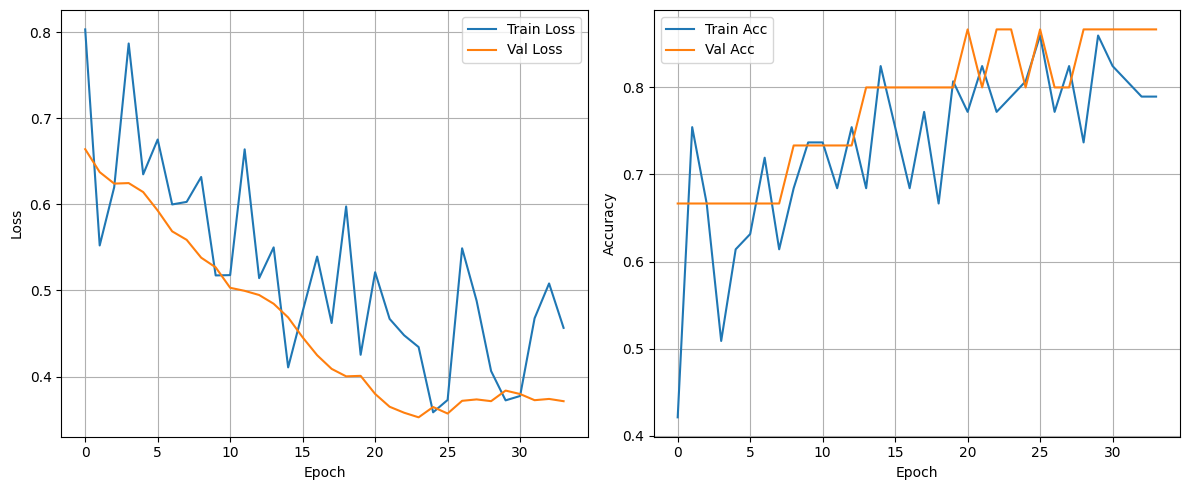

In [71]:
# Load metrics
metrics = pd.read_csv(f"{log_dir}/{experiment_name}/version_3/metrics.csv")

# Print available columns to verify
print("Available columns:", metrics.columns.tolist())

# Filter out rows with NaN epoch values
metrics = metrics.dropna(subset=['epoch'])

# Convert epoch to integer (important for proper sorting)
metrics['epoch'] = metrics['epoch'].astype(int)

# Get epochs that have both training and validation data
train_epochs = set(metrics.dropna(subset=['train/loss_epoch'])['epoch'].unique())
val_epochs = set(metrics.dropna(subset=['val/loss'])['epoch'].unique())
common_epochs = sorted(list(train_epochs.intersection(val_epochs)))

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

# Group by epoch and get mean values for common epochs only
train_loss = metrics[metrics['epoch'].isin(common_epochs)].groupby('epoch')['train/loss_epoch'].mean()
val_loss = metrics[metrics['epoch'].isin(common_epochs)].groupby('epoch')['val/loss'].mean()

plt.plot(common_epochs, train_loss, label="Train Loss")
plt.plot(common_epochs, val_loss, label="Val Loss") 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)

# Group by epoch and get mean values for common epochs only
train_acc = metrics[metrics['epoch'].isin(common_epochs)].groupby('epoch')['train/acc_epoch'].mean()
val_acc = metrics[metrics['epoch'].isin(common_epochs)].groupby('epoch')['val/acc'].mean()

plt.plot(common_epochs, train_acc, label="Train Acc")
plt.plot(common_epochs, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()